In [1]:
import generator
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Activation,LSTM,Bidirectional,Embedding,Conv2D,BatchNormalization,Activation,Masking,LeakyReLU
from tensorflow.keras.activations import tanh,relu
from tensorflow.keras.models import Model
from tensorflow.keras import Model as models
import numpy as np
import librosa
import matplotlib.pyplot as plt
import logging, os
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import OneHotEncoder as one_hot
import sys
import sentencepiece as spm
import pandas as pd
import csv

logging.disable(logging.WARNING)
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

from IPython.display import display
from time import sleep

print('Test 1')
dh = display('Test2',display_id=True)
sleep(1)
dh.update('Test3')

files , json,json_word = generator.gen()
files2 = generator.gen2()
maxi = 1021

def expdim(x,axis):
    return tf.expand_dims(x,axis=axis)

Test 1


'Test3'

In [2]:
def mel_convert(wav):
    def preemphasis(samples, coeff=0.97):
        return np.append(samples[0], samples[1:] - coeff * samples[:-1])

    num_features = 80
    eps = 2 ** -24
    n_fft=512
    win_length=20e-3
    hop_length=10e-3
    center=False
    test = wav
    test = librosa.util.normalize(test)
    test = preemphasis(test, coeff=0.97)
    stft = librosa.stft(test, n_fft=n_fft,
                                win_length=int(win_length*16000),
                                hop_length=int(hop_length*16000),
                                center=center)
    features = np.abs(stft)
    test = features.astype(np.float32)
    normalize='all_features'


    sample_rate = 16000
    mel_basis = librosa.filters.mel(sr=sample_rate,
                                                     n_fft=n_fft,
                                                     n_mels=num_features,
                                                     fmin=0,
                                                     fmax=sample_rate/2,
                                                     htk=False)
    mag = test

    features = np.log(np.dot(mel_basis, mag*mag) + eps)

    # normalize
    if normalize == 'all_features':
        m = np.mean(features)
        s = np.std(features) #+ 1e-5
        features = (features - m) / s
    elif normalize == 'per_feature':
        m = np.mean(features, axis=1, keepdims=True)
        s = np.std(features, axis=1, keepdims=True) + 1e-5
        features = (features - m) / s

    test = features.astype(np.float32)

    return test

In [3]:
files2

{'1673-143396-0000': {'file_path': '/root/storage/DATA/LibriSpeech/dev-clean/1673/143396/1673-143396-0000.wav',
  'file_txt': 'a laudable regard for the honor of the first proselyte has countenanced the belief the hope the wish that the ebionites or at least the nazarenes were distinguished only by their obstinate perseverance in the practice of the mosaic rites\n'},
 '1673-143396-0001': {'file_path': '/root/storage/DATA/LibriSpeech/dev-clean/1673/143396/1673-143396-0001.wav',
  'file_txt': 'their churches have disappeared their books are obliterated their obscure freedom might allow a latitude of faith and the softness of their infant creed would be variously moulded by the zeal or prudence of three hundred years\n'},
 '1673-143396-0002': {'file_path': '/root/storage/DATA/LibriSpeech/dev-clean/1673/143396/1673-143396-0002.wav',
  'file_txt': 'yet the most charitable criticism must refuse these sectaries any knowledge of the pure and proper divinity of christ\n'},
 '1673-143396-0003': 

In [4]:
sens = []
for i in files2:
    sens.append(files2[i]['file_txt'])
    

In [5]:
with open('imdb_review.txt', 'w', encoding='utf8') as f:
    f.write('/n'.join(sens))

In [6]:
spm.SentencePieceTrainer.Train('--input=imdb_review.txt --model_prefix=imdb --vocab_size=5000 --model_type=bpe --max_sentence_length=9999 --pad_id=0 --unk_id=1 --bos_id=2 --eos_id=3')

In [7]:
vocab_list = pd.read_csv('imdb.vocab', sep='\t', header=None, quoting=csv.QUOTE_NONE)

In [8]:
vocab_list.sample(10)

,0,1
522,▁nothing,-518
3677,▁market,-3673
861,▁hel,-857
203,▁been,-199
3483,▁toil,-3479
4435,▁rigid,-4431
1129,iled,-1125
3461,▁meat,-3457
73,ver,-69
565,ru,-561


In [9]:
sp = spm.SentencePieceProcessor()
vocab_file = "imdb.model"
sp.load(vocab_file)

True

In [10]:
lines = [
  "I didn't at all think of it this way.",
  "I have waited a long time for someone to film"
]
for line in lines:
    print(line)
    print(sp.encode_as_pieces(line))
    print(sp.encode_as_ids(line))
    print()

I didn't at all think of it this way.
['▁', 'I', '▁didn', "'", 't', '▁at', '▁all', '▁think', '▁of', '▁it', '▁this', '▁way', '.']
[4972, 1, 3434, 4996, 4974, 102, 132, 490, 27, 65, 181, 545, 1]

I have waited a long time for someone to film
['▁', 'I', '▁have', '▁waited', '▁a', '▁long', '▁time', '▁for', '▁some', 'one', '▁to', '▁f', 'il', 'm']
[4972, 1, 168, 3124, 6, 381, 283, 86, 263, 211, 31, 21, 117, 4985]



In [11]:
wav_list = []
txt_list = []
max_wav = 0
max_txt = 0
for i,num in enumerate(files2):
    if i%20==0:
        print(i)
    wav,_ = librosa.load(files2[num]['file_path'],sr=16000)
    mel = mel_convert(wav)
    wav_list.append(mel)
    
    if mel.shape[1] > max_wav:
        max_wav = mel.shape[1]
    if len(files2[num]['file_txt']) > max_txt:
        max_txt = len(files2[num]['file_txt'])
    
    txt_list.append([2]+sp.encode_as_ids(files2[num]['file_txt'])+[3])

0
20
40
60
80
100
120
140
160
180
200
220
240
260
280
300
320
340
360
380
400
420
440
460
480
500
520
540
560
580
600
620
640
660
680
700
720
740
760
780
800
820
840
860
880
900
920
940
960
980
1000
1020
1040
1060
1080
1100
1120
1140
1160
1180
1200
1220
1240
1260
1280
1300
1320
1340
1360
1380
1400
1420
1440
1460
1480
1500
1520
1540
1560
1580
1600
1620
1640
1660
1680
1700
1720
1740
1760
1780
1800
1820
1840
1860
1880
1900
1920
1940
1960
1980
2000
2020
2040
2060
2080
2100
2120
2140
2160
2180
2200
2220
2240
2260
2280
2300
2320
2340
2360
2380
2400
2420
2440
2460
2480
2500
2520
2540
2560
2580
2600
2620
2640
2660
2680
2700


In [12]:
mask_list = wav_list.copy()

for i,(wav,txt) in enumerate(zip(wav_list,txt_list)):
    wav_pad = np.zeros((max_wav-wav.shape[1],80))
    mask = np.ones((max_wav-wav.shape[1],80))
    wav_list[i] = np.expand_dims(np.concatenate([wav.reshape([wav.shape[1],wav.shape[0]]),wav_pad],axis=0),axis=0)
    mask_list[i] = np.expand_dims(wav.shape[1],0)
    
    txt_pad = np.zeros((max_txt-len(txt)))
    txt_list[i] = np.expand_dims(np.concatenate([txt,txt_pad],axis=0),axis=0)
    
txt_list = np.concatenate(txt_list,axis=0)
wav_list = np.concatenate(wav_list,axis=0)
mask_list = np.concatenate(mask_list,axis=0)

In [13]:
sp.decode_ids(txt_list[32].astype(int).tolist())

'nestorius who depended on the near approach of his eastern friends persisted like his predecessor chrysostom to disclaim the jurisdiction and to disobey the summons of his enemies they hastened his trial and his accuser presided in the seat of judgment'

In [14]:
wav_list.shape

(2703, 3262, 80)

In [15]:
class pre_net(tf.keras.layers.Layer):
    def __init__(self,num_m=2,n=64,c=64):
        super(pre_net,self).__init__()
        self.num_m = num_m
        self.pre_seq = tf.keras.Sequential([
            tf.keras.layers.Masking(mask_value=0.),
            tf.keras.layers.Conv2D(n,3,2,'same',activation='tanh',
                                                kernel_initializer='glorot_normal'),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Masking(mask_value=0.),
            tf.keras.layers.Conv2D(n,3,2,'same',activation='tanh',
                                                kernel_initializer='glorot_normal'),
            tf.keras.layers.BatchNormalization()])
        
        self.TwoD_layers = [TwoD_Attention_layer(n,c) for _ in range(self.num_m)]
        
    def call(self,inputs):
        x = tf.cast(inputs,tf.float32)
        x = self.pre_seq(x)
        for layer in self.TwoD_layers:
            x = layer(x)
        
        return x

In [16]:
def scaled_dot_att(q,k,v,mask=None):
    #when 2d_att_time
    # (q,k,v) = B * C * T * D = 2,64,816,20
    #when 2d_att_fre
    # (q,k,v) = B * C * D * T = 2,64,20,816
    
    matmul_qk = tf.matmul(q,k,transpose_b=True)
    # 2,64,816,816
    # 2,64,20,20
    
    dk = tf.cast(k.shape[-1],tf.float32) #get dims of T or D
    scaled_att_logit = matmul_qk / tf.cast(tf.math.sqrt(dk),matmul_qk.dtype)
    
    if mask is not None:
        if type(mask) is np.ndarray:
            mask_arr = np.zeros(matmul_qk.shape)
        scaled_att_logit += tf.cast((mask * -1e9),scaled_att_logit.dtype)
    
    #print(scaled_att_logit)
    attention_weights = tf.nn.softmax(scaled_att_logit,axis=-1)
    # B * C * T * T / B * C * D * D
    
    attention_matrix = tf.matmul(attention_weights,v)
    # B * C * T * D / B * C * D * T

    return attention_matrix , attention_weights
    

class TwoD_Attention_layer(tf.keras.layers.Layer):
    def __init__(self,n=64,c=64):
        super(TwoD_Attention_layer,self).__init__()
        self.n = n
        self.c = c
        self.convq = tf.keras.layers.Conv2D(c,3,1,'same',kernel_initializer='glorot_normal')
        self.convk = tf.keras.layers.Conv2D(c,3,1,'same',kernel_initializer='glorot_normal')
        self.convv = tf.keras.layers.Conv2D(c,3,1,'same',kernel_initializer='glorot_normal')
        self.conv = tf.keras.layers.Conv2D(c,3,1,'same',kernel_initializer='glorot_normal')
        
        self.bnq = tf.keras.layers.BatchNormalization()
        self.bnk = tf.keras.layers.BatchNormalization()
        self.bnv = tf.keras.layers.BatchNormalization()
        self.ln = tf.keras.layers.LayerNormalization()
        
        self.final_conv1 = tf.keras.layers.Conv2D(n,3,1,'same',activation='relu',
                                                 kernel_initializer='glorot_normal')
        self.final_conv2 = tf.keras.layers.Conv2D(n,3,1,'same',)
        
        self.bnf1 = tf.keras.layers.BatchNormalization()
        self.bnf2 = tf.keras.layers.BatchNormalization()
        
        self.act = tf.keras.layers.Activation('relu')
        
    def call(self, inputs):
        
        residual = inputs
        batch_size = inputs.shape[0]
        q = self.bnq(self.convq(inputs))
        k = self.bnk(self.convk(inputs))
        v = self.bnv(self.convv(inputs))
        
        print(q.shape,k.shape,v.shape)
        
        q_time = tf.transpose(q,[0,3,1,2])
        k_time = tf.transpose(k,[0,3,1,2])
        v_time = tf.transpose(v,[0,3,1,2])
        # B * C * T * D = 2,64,816,20
        
        q_fre = tf.transpose(q,[0,3,2,1])
        k_fre = tf.transpose(k,[0,3,2,1])
        v_fre = tf.transpose(v,[0,3,2,1])
        # B * C * D * T = 2,64,20,816
        
        scaled_att_time, att_weights_time = scaled_dot_att(q_time,k_time,v_time)
        # B * C * T * D
        scaled_att_fre, att_weights_fre = scaled_dot_att(q_fre,k_fre,v_fre)
        # B * C * D * T
        
        mat = [scaled_att_time,scaled_att_fre]
        weight = [att_weights_time, att_weights_fre]
        
        scaled_att_time = tf.transpose(scaled_att_time,[0,2,3,1]) 
        # B * T * D * C
        scaled_att_fre = tf.transpose(scaled_att_fre,[0,3,2,1])
        # B * T * D * C
        
        out = tf.concat([scaled_att_time,scaled_att_fre],-1)
        # B * T * D * 2C
        
        out = self.ln(self.conv(out) + residual)
        
        final_out = self.bnf1(self.final_conv1(out))
        final_out = self.bnf2(self.final_conv2(final_out))
        
        final_out = self.act(final_out + out)
        
        return  final_out

In [25]:
tt = pre_net(num_m=4)
print(np.expand_dims(wav_list[:2],axis=3).shape)
res = tt(np.expand_dims(wav_list[:2],axis=3))
print(res.shape)

(2, 3262, 80, 1)
(2, 816, 20, 64) (2, 816, 20, 64) (2, 816, 20, 64)
(2, 816, 20, 64) (2, 816, 20, 64) (2, 816, 20, 64)
(2, 816, 20, 64) (2, 816, 20, 64) (2, 816, 20, 64)
(2, 816, 20, 64) (2, 816, 20, 64) (2, 816, 20, 64)
(2, 816, 20, 64)


In [17]:
def get_angles(pos,i,d_model):
    angle_rates = 1/np.power(10000,(2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position,d_model):
    angle_rads = get_angles(np.arange(position)[:,np.newaxis],
                           np.arange(d_model)[np.newaxis,:],d_model)
    
    sines = np.sin(angle_rads[:,0::2])
    cosines = np.cos(angle_rads[:,1::2])
    
    pos_encoding = np.concatenate([sines,cosines],axis=-1)
    pos_encoding = pos_encoding[np.newaxis, ...]
    
    return tf.cast(pos_encoding,dtype=tf.float32)

In [18]:
positional_encoding(3,16)

<tf.Tensor: shape=(1, 3, 16), dtype=float32, numpy=
array([[[ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00,
          1.0000000e+00,  1.0000000e+00,  1.0000000e+00,  1.0000000e+00],
        [ 8.4147096e-01,  3.1098360e-01,  9.9833414e-02,  3.1617507e-02,
          9.9998331e-03,  3.1622723e-03,  9.9999981e-04,  3.1622776e-04,
          5.4030228e-01,  9.5041525e-01,  9.9500418e-01,  9.9950004e-01,
          9.9994999e-01,  9.9999499e-01,  9.9999952e-01,  9.9999994e-01],
        [ 9.0929741e-01,  5.9112710e-01,  1.9866933e-01,  6.3203394e-02,
          1.9998666e-02,  6.3245133e-03,  1.9999987e-03,  6.3245551e-04,
         -4.1614684e-01,  8.0657840e-01,  9.8006660e-01,  9.9800068e-01,
          9.9980003e-01,  9.9997997e-01,  9.9999797e-01,  9.9999982e-01]]],
      dtype=float32)>

In [19]:
class Encoder(tf.keras.Model):
    def __init__(self, num_layers, d_model, num_heads, dff, pe_max_len,name,dp=0.1):
        super(Encoder,self).__init__()
        
        self.d_model = d_model
        self.num_layers = num_layers
        self.rate = dp
        
        self.pos_encoding = positional_encoding(pe_max_len,self.d_model)
        
        self.input_proj = tf.keras.models.Sequential([
            
            #tf.keras.layers.Masking(mask_value=0.),
            # modified
            tf.keras.layers.Dense(units=self.d_model,kernel_initializer='glorot_normal'),
            tf.keras.layers.LayerNormalization(epsilon=1e-6),
        ])
        
        self.dropout = tf.keras.layers.Dropout(rate=0.1)
        self.enc_layers = [EncoderLayer(d_model,num_heads, dff, 'En'+str(_),dp)
                          for _ in range(num_layers)]
        
    def call(self,inputs,training=True,mask=None):
        x = inputs[0]
        #x = inputs
        mask = inputs[1]
        seq_len = x.shape[1]
        
        x = tf.reshape(x,[x.shape[0],x.shape[1],-1]) # B * T * (D * n)
        x = self.input_proj(x) # B * T * d_model
        
        x += tf.cast(self.pos_encoding[:,:seq_len,:],x.dtype)
        plt.imshow(x[0])
        
        x = self.dropout(x,training=training)
        
        for i in range(self.num_layers):
            x = self.enc_layers[i](x,training,mask)
        
        return x # B * T * d_model

In [20]:
def pwff_net(d_model, dff):
    return tf.keras.Sequential([
      tf.keras.layers.Dense(dff,kernel_initializer='glorot_normal', activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model,kernel_initializer='glorot_normal')]) # (batch_size, seq_len, d_model)])

class EncoderLayer(tf.keras.layers.Layer):
    def __init__(self,d_model, num_heads, dff, name, rate=0.1):
        super(EncoderLayer,self).__init__(name=name)
        
        self.mha = MultiHeadAttention(d_model,num_heads)
        self.ffn = pwff_net(d_model,dff)
        
        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e6,name=name+'_LN1')
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e6,name=name+'_LN2')
        
        self.dropout1 = tf.keras.layers.Dropout(rate,name=name+'_dp1')
        self.dropout2 = tf.keras.layers.Dropout(rate,name=name+'_dp2')

    def call(self, inputs, training, mask):
        attn_output, slf_attn_weight = self.mha(inputs, inputs, inputs, mask)  # (batch_size, input_seq_len, d_model)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)  # (batch_size, input_seq_len, d_model)

        ffn_output = self.ffn(out1)  # (batch_size, input_seq_len, d_model)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, input_seq_len, d_model)

        return out2

In [21]:
class MultiHeadAttention(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention,self).__init__()
        
        self.d_model = d_model
        self.num_heads = num_heads
        
        assert self.d_model % self.num_heads == 0
        
        self.depth = self.d_model//self.num_heads
        
        init = tf.keras.initializers.RandomNormal(mean=0,stddev=np.sqrt(2.0/(d_model+self.depth)))
        
        self.wq = tf.keras.layers.Dense(d_model,kernel_initializer=init)
        self.wk = tf.keras.layers.Dense(d_model,kernel_initializer=init)
        self.wv = tf.keras.layers.Dense(d_model,kernel_initializer=init)
        
        self.dense = tf.keras.layers.Dense(d_model,kernel_initializer='glorot_normal')
        
    def split_heads(self, x, batch_size):
        
        x = tf.reshape(x,(batch_size,-1,self.num_heads,self.depth))
        return tf.transpose(x,[0,2,1,3])
    
    def call(self,q,k,v,mask):
        
        batch_size = q.shape[0]

        # B * T * d_model
        q = self.wq(q)
        k = self.wk(k)
        v = self.wv(v)
        
        # B * num_h * T * depth
        q = self.split_heads(q,batch_size)
        k = self.split_heads(k,batch_size)
        v = self.split_heads(v,batch_size)
        
        attention, weights = scaled_dot_att(q,k,v,mask)
        
        print(attention.shape)
        
        attention = tf.transpose(attention,[0,2,1,3]) # B * T * num_h * depth
        
        attention = tf.reshape(attention,(batch_size,-1,self.d_model))
        
        output = self.dense(attention)
    
        return output,weights

In [71]:
wav_list[0][1465]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [68]:
mask_list[0][1465]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [86]:
res1.shape

TensorShape([1, 816, 20, 64])

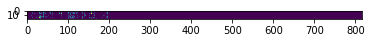

In [94]:
plt.imshow(tf.transpose(res1[0,:,:,0]))

In [31]:
np.ones(res1.shape)

array([[[[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.]],

        ...,

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
    

(1, 816, 20, 64) (1, 816, 20, 64) (1, 816, 20, 64)
(1, 816, 20, 64) (1, 816, 20, 64) (1, 816, 20, 64)
(1, 816, 20, 64) (1, 816, 20, 64) (1, 816, 20, 64)
(1, 816, 20, 64) (1, 816, 20, 64) (1, 816, 20, 64)
(1, 196, 20, 64) (1, 196, 20, 64) (1, 196, 20, 64)
(1, 196, 20, 64) (1, 196, 20, 64) (1, 196, 20, 64)
(1, 196, 20, 64) (1, 196, 20, 64) (1, 196, 20, 64)
(1, 196, 20, 64) (1, 196, 20, 64) (1, 196, 20, 64)
620


InvalidArgumentError: Incompatible shapes: [1,8,816,816] vs. [1,816,20,64] [Op:AddV2] name: encoder_1/En0/multi_head_attention_4/add/

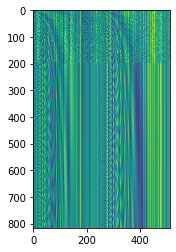

In [38]:
pnet = pre_net(4)
res1 = pnet(np.expand_dims(np.expand_dims(wav_list[2],axis=0),3))
reshape = res1.shape
test = np.ndarray((1,mask_list[2],80,1))
result = pnet(test).shape
diff = reshape[1] - result[1]
print(diff)

encenc = Encoder(4,512,8,8,3262,'test')
rerrere = encenc((res1,diff))

In [39]:
mask

array([[[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],

        ...,

        [[1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
         ...,
         [1., 1., 1., ..., 1., 1., 1.],
         [1., 1., 1., ..., 1., 1., 1.],
    

(1, 196, 20, 64) (1, 196, 20, 64) (1, 196, 20, 64)
(1, 196, 20, 64) (1, 196, 20, 64) (1, 196, 20, 64)
(1, 196, 20, 64) (1, 196, 20, 64) (1, 196, 20, 64)
(1, 196, 20, 64) (1, 196, 20, 64) (1, 196, 20, 64)


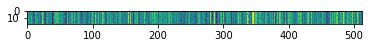

In [65]:
plt.imshow(tf.squeeze(rerrere))

In [53]:
seq = tf.convert_to_tensor(wav_list[0])
re= tf.math.equal(seq, 0.)

In [55]:
re[79]

<tf.Tensor: shape=(1465,), dtype=bool, numpy=array([False, False, False, ..., False, False, False])>

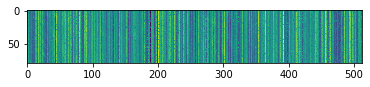

In [41]:
plt.imshow(rerrere[0])

In [491]:
class Dec(tf.keras.Model):
    def __init__(self,n_layer):
        self.n_layer = n_layer
    
    def call:
        
    

In [493]:
dec = Dec(5)